In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
trials = 10000
stddev = 3
correlation_frac = 0.1
nants = 352
autocorr_fractional_error = np.zeros(trials, dtype=float)
crosscorr_fractional_error = np.zeros(trials, dtype=float)

for trial_ind in range(trials):

    # Define random Gaussian per-antenna signals
    antenna_values = np.random.normal(
        scale=stddev, size=(nants)
    ) + 1j * np.random.normal(scale=stddev, size=(nants))
    #plt.scatter(np.real(antenna_values), np.imag(antenna_values))
    correlation_mat = np.full((nants, nants), correlation_frac, dtype=float)
    np.fill_diagonal(correlation_mat, 1)
    normalization_factor = np.sqrt(np.matmul(correlation_mat, np.conj(correlation_mat.T))[0, 0])
    correlation_mat /= normalization_factor
    antenna_values = np.matmul(correlation_mat, antenna_values)
    #plt.scatter(np.real(antenna_values), np.imag(antenna_values))
    #plt.show()

    # Quantize values to integers [-7, 7]
    antenna_values_quantized_real_part = np.round(np.real(antenna_values))
    antenna_values_quantized_real_part[
        np.where(antenna_values_quantized_real_part < -7)
    ] = -7
    antenna_values_quantized_real_part[np.where(antenna_values_quantized_real_part > 7)] = 7
    antenna_values_quantized_imag_part = np.round(np.imag(antenna_values))
    antenna_values_quantized_imag_part[
        np.where(antenna_values_quantized_imag_part < -7)
    ] = -7
    antenna_values_quantized_imag_part[np.where(antenna_values_quantized_imag_part > 7)] = 7
    antenna_values_quantized = (
        antenna_values_quantized_real_part + 1j * antenna_values_quantized_imag_part
    )

    # Calculate autocorrelations
    autocorrs_orig = antenna_values * np.conj(antenna_values)
    autocorrs_quantized = antenna_values_quantized * np.conj(antenna_values_quantized)
    #plt.plot(autocorrs_orig)
    #plt.plot(autocorrs_quantized)

    # Calculate cross correlations
    crosscorrs_orig = antenna_values[:, np.newaxis] * np.conj(
        antenna_values[np.newaxis, :]
    )
    crosscorrs_quantized = antenna_values_quantized[:, np.newaxis] * np.conj(
        antenna_values_quantized[np.newaxis, :]
    )
    # Mask autocorrelations and conjugated values
    crosscorrs_orig[np.tril_indices(nants, k=0)] = np.nan
    crosscorrs_quantized[np.tril_indices(nants, k=0)] = np.nan

    # Calculate fractional error
    autocorr_fractional_error[trial_ind] = (
        np.abs(autocorrs_orig - autocorrs_quantized) / np.abs(autocorrs_orig)
    )[0]
    crosscorr_fractional_error[trial_ind] = (
        np.abs(crosscorrs_orig - crosscorrs_quantized) / np.abs(crosscorrs_orig)
    )[0,2]

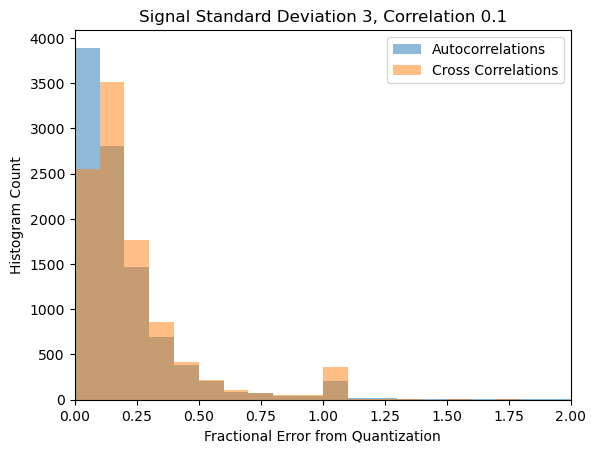

In [10]:
# hist_max = np.max(
#    [np.nanmax(autocorr_fractional_error), np.nanmax(crosscorr_fractional_error)]
# )
hist_max = 2
plt.hist(autocorr_fractional_error, bins=20, range=(0, hist_max), alpha=.5, label="Autocorrelations")
plt.hist(
    crosscorr_fractional_error,
    bins=20,
    range=(0, hist_max),
    alpha=0.5,
    label="Cross Correlations",
)
plt.xlabel("Fractional Error from Quantization")
plt.ylabel("Histogram Count")
plt.title(f"Signal Standard Deviation {stddev}, Correlation {correlation_frac}")
plt.xlim((0, hist_max))
plt.legend()